In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib

from IPython.core.pylabtools import figsize
figsize(11, 5)


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import copy

In [5]:
# Path for saving the network
PATH = 'saved/HintonFamily.pth'

# Algoritmo de entrenamiento por retropropagación (*backpropagation*)

## Un ejemplo de Geoffrey Hinton
Ejemplo tomado de:
"Aprendiendo representaciones distribuidas de conceptos" en
http://www.cogsci.ucsd.edu/~ajyu/Teaching/Cogs202_sp12/Readings/hinton86.pdf
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.408.7684&rep=rep1&type=pdf

Hinton, G. E. (1986).  Learning distributed representations of concepts.  In
Proceedings of the Eighth Annual Conference of the Cognitive Science Society, pages 1–12. Erlbaum, NJ.

<img src="figuras/ArbolGenealogico.png"/>

Relaciones:
  * hijo
  * hija
  * sobrino
  * sobrina
  * padre
  * madre
  * tío
  * tía
  * hermano
  * hermana
  * esposo
  * esposa
  
Proposiciones:
  * (colin tiene-padre james)
  * (colin tiene-madre victoria)
  * (james tiene-esposa victoria)
  
Objetivo:
  Que la red siguiente indique la segunda persona de la tercia, dados los valores en las dos primeras posiciones.
  
Diseño de la red:
  1. Capa uno:
     * 24 neuronas de entrada, una para cada persona
     * 12 neuronas de entrada, una para cada relación
  2. Capa dos:
     * 6 neuronas conectadas con las 24 personas.
     * 6 neuronas conectadas con las 12 relaciones.
  3. Capa tres:
     * 12 neuronas conectadas a todas las neuronas en la capa 2.
  4. Capa cuatro:
     * 6 neuronas conectadas a todas las neuronas en la capa 3.
  5. Capa cinco:
     * 24 neuronas de salida, una para cada persona relacionada con la de entrada.
     
Datos de entrada:
  * 112 proposiciones, 100 utilizadas para entrenamiento, con 1500 pasadas.
  
<img src="figuras/RedHinton86.png"/>

In [6]:
import numpy as np

from RedHinton import data

@interact(index = (0, len(data.tercias) - 1))
def muestraRelacion(index):
    print(data.tercias[index])

interactive(children=(IntSlider(value=55, description='index', max=111), Output()), _dom_classes=('widget-inte…

In [7]:
# De todas las relaciones, eliminaremos la persona 2.
# Lo cual nos deja con:
print(len(data.unicas), " posibles entradas.")

104  posibles entradas.


In [8]:
# Las entradas distintas que quedan son:

@interact(index = (0, len(data.unicas) - 1))
def muestraRelacion(index):
    print(data.unicas[index])

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [9]:
muestraRelacion(10)

['Charlotte' 'tiene-tia']


In [10]:
# Pasar las relaciones a vectores de entrada numéricos para la red neuronal
# Tómese en cuenta que, para cada entrada, puede haber más de una respuesta.

total = data.total
Datos = data.Datos
Salidas = data.Salidas

personas = data.personas
relaciones = data.relaciones

print(personas)
print(relaciones)

['Christopher', 'Penelope', 'Andrew', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'James', 'Jennifer', 'Charles', 'Colin', 'Charlotte', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Gina', 'Emilio', 'Lucia', 'Marco', 'Angela', 'Tomaso', 'Alfonso', 'Sophia']
['tiene-esposa', 'tiene-esposo', 'tiene-padre', 'tiene-madre', 'tiene-hermano', 'tiene-hermana', 'tiene-hijo', 'tiene-hija', 'tiene-tio', 'tiene-tia', 'tiene-sobrino', 'tiene-sobrina']


In [11]:
# Funciones cómodas para pasar del código en las neuronas a la representación
# simbólica
def codificaPersona(persona):
    """ Devuele un vector columna con los valores de activación
    correspondientes a la persona solicitada.
    """
    codigo = np.zeros((len(personas), 1))
    codigo[personas.index(persona)] = 1
    return codigo

def decodificaPersona(codigoPersonas, threshold = 0.5):
    """ Devuelve la lista de personas indicadas por el código.
    """
    personas_decod = []
    for i, val in enumerate(codigoPersonas):
        if val >= threshold:
            personas_decod.append(personas[i])
    return personas_decod

def codificaRelacion(relacion):
    """ Devuele un vector columna con los valores de activación
    correspondientes a la persona solicitada.
    """
    codigo = np.zeros((len(relaciones), 1))
    codigo[relaciones.index(relacion)] = 1
    return codigo

def decodificaRelacion(codigoRel):
    """ Devuelve la lista de todas las relaciones indicadas
    por el código.
    """
    relaciones_decod = []
    for i, val in enumerate(codigoRel):
        if val >= 0.5:
            relaciones_decod.append(relaciones[i])
    return relaciones_decod

In [12]:
@interact(index = (0, len(personas) - 1))
def muestraCodigoPersona(index):
    print(personas[index], codificaPersona(personas[index]).T)

interactive(children=(IntSlider(value=11, description='index', max=23), Output()), _dom_classes=('widget-inter…

In [13]:
@interact(index = (0, len(relaciones) - 1))
def muestraCodigoRelacion(index):
    print(relaciones[index], codificaRelacion(relaciones[index]).T)

interactive(children=(IntSlider(value=5, description='index', max=11), Output()), _dom_classes=('widget-intera…

In [14]:
@interact(index = (0, total - 1))
def muestraCodigoSalida(index):
    print(decodificaPersona(Datos[index,0:len(personas)]),
          decodificaRelacion(Datos[index,len(personas):]))
    print(Datos[index])
    print(decodificaPersona(Salidas[index]))
    print(Salidas[index])

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [15]:
# Verificar que las personas estén bien codificadas en la pregunta
for i, relNum in enumerate(Datos):
    decod = decodificaPersona(relNum[0:len(personas)])
    if (decod[0] != data.unicas[i][0] or len(decod) > 1):
        raise Exception("Persona mal codificada ", unicas[i][0], decod)
    #print(unicas[i][0], decod)
    
# Verificar que las relaciones estén bien codificadas
for i, relNum in enumerate(Datos):
    decod = decodificaRelacion(relNum[len(personas):])
    if (decod[0] != data.unicas[i][1] or len(decod) > 1):
        raise Exception("Relación mal codificada ", unicas[i][1], decod)
    #print(unicas[i][1], decod)

In [16]:
# Utilizaremos 100 relaciones para el entrenamiento y dejaremos 4 para probar qué pasa.

# Asignar la semilla para que todos los números aleatorios generados sean siempre los mismos
np.random.seed(10)
from numpy.random import RandomState

rndState = RandomState(42)

# Elegimos 100 ejemplares, después de revolver los datos
permutacion = rndState.permutation(total)

m = 100
X = torch.tensor(Datos[permutacion][0:m])
Y = torch.tensor(Salidas[permutacion][0:m])

mTest = 4
XTest = torch.tensor(Datos[permutacion][m:])
YTest = torch.tensor(Salidas[permutacion][m:])

# Verificamos que 'tiene-tio' y 'tiene-tia' estén incluidos..

In [17]:
@interact(index = (0, m - 1))
def muestraCodigoSalida(index):
    print(decodificaPersona(X[index,0:len(personas)]),
          decodificaRelacion(X[index,len(personas):]))
    print(X[index])
    print(decodificaPersona(Y[index]))
    print(Y[index])

interactive(children=(IntSlider(value=49, description='index', max=99), Output()), _dom_classes=('widget-inter…

## Red neuronal multicapa

### Alimentación

Ya tenemos datos para realizar nuestros experimentos.  Procedamos a programar la evaluación de la red neuronal multicapa.

Comencemos por programar una función que evalúe la salida de una sección contigua de neuronas en una capa, dadas sus entradas.  Utilizando notación matricial, es posible evaluarlas todas en paralelo.

\begin{align}
 a_i^{(l+1)} &= g\left(\sum_j \theta_{i,j}^{(l)} a_j^{(l)}\right) \\
 g &= \frac{1}{1 + e^{-x}} \\
\end{align}
\begin{equation}
 \begin{bmatrix}
  a_0^{(l+1)} \\
  a_1^{(l+1)} \\
  ... \\
  a_{n'}^{(l+1)}
 \end{bmatrix} = g \left(
 \begin{bmatrix}
  \theta_{10}^{(l)} & ... & \theta_{1n}^{(l)} \\
  ... \\
  \\
  \theta_{n'0}^{(l)} & ... & \theta_{n'n}^{(l)} \\
 \end{bmatrix}
 \begin{bmatrix}
  a_0^{(l)} \\
  a_1^{(l)} \\
  ... \\
  a_n^{(l)}
 \end{bmatrix} \right)
\end{equation}

donde $a_i^{(l)}$ es el valor de activación de la neurona $i$ en la capa $l$ y $\theta_{ij}^{(l)}$ el peso del arista que conecta a la neurona $a_j^{(l)}$ con la neurona $a_i^{(l+1)}$.

La función de activación $g$ se evalúa sobre el vector, componente por componente.

Ahora es necesario programar una función para evaluar los valores de activación de las neuronas en cada segmento de la red neuronal:

<img src="figuras/RedRelaciones.png" />



Observemos que el número de pesos conectando las diferentes capas son:
  * $W^{A1} \rightarrow (6 \times 24) = 144$
  * $W^{A2} \rightarrow (6 \times 12) = 72$
  * $W^{B} \rightarrow (12 \times 12) = 144$
  * $W^{C} \rightarrow (6 \times 12) = 72$
  * $W^{D} \rightarrow (24 \times 6) = 144$
  
Lo cual da un total de **576** pesos, cuyo valor debe ser ajustado.

In [18]:
print(len(personas))
print(len(relaciones))

24
12


In [19]:
class ModeloFamiliar(nn.Module):
    """
    Red neuronal para modelar relaciones simbólicas, que corresponden a árboles familiares ficticios.
    """
    
    def __init__(self):
        """ Inicializa las combinaciones lineales para cada capa. """
        super(ModeloFamiliar, self).__init__()
        # El bias lo agrega PyTorch por defecto, ya que este ejercicio no lo usa, hay que quitarlo
        self.num_personas = len(personas)
        self.num_relaciones = len(relaciones)
        self.zb_1 = nn.Linear(self.num_personas, 6, bias=False)
        self.zb_2 = nn.Linear(self.num_relaciones, 6, bias=False)
        self.zc = nn.Linear(12, 12, bias=False)
        self.zd = nn.Linear(12, 6, bias=False)
        self.ze = nn.Linear(6, 24, bias=False)
        
    def forward(self, X):
        """
        Función del módulo que obtiene a la segunda persona en la relación,
        dada la primera persona y la relación.
        """
        # Separar X
        self.a_1 = X[:,:self.num_personas]
        self.a_2 = X[:,self.num_personas:]
        self.b_1 = torch.sigmoid(self.zb_1(self.a_1))
        self.b_2 = torch.sigmoid(self.zb_2(self.a_2))
        self.b = torch.cat((self.b_1, self.b_2), 1)
        self.c = torch.sigmoid(self.zc(self.b))
        self.d = torch.sigmoid(self.zd(self.c))
        self.e = torch.sigmoid(self.ze(self.d))
        return self.e
    
    def setWeightsToOnes(self):
        """
        Hacer que todos los pesos valgan uno.
        Útil para probar que la red funcione.
        Nota: ¿es necesario cuando se usa pyTorch?
        """
        # TODO: Opción de cargar una red con los pesos dados. Ej: sólo unos para pruebas
        self.zb_1.weight.data = torch.ones(self.zb_1.weight.data.size(), dtype=torch.double)
        self.zb_2.weight.data = torch.ones(self.zb_2.weight.data.size(), dtype=torch.double)
        self.zc.weight.data = torch.ones(self.zc.weight.data.size(), dtype=torch.double)
        self.zd.weight.data = torch.ones(self.zd.weight.data.size(), dtype=torch.double)
        self.ze.weight.data = torch.ones(self.ze.weight.data.size(), dtype=torch.double)

In [20]:
# Primera prueba al funcionamiento de la red
RH_0 = ModeloFamiliar()
RH_0.setWeightsToOnes()
RH_0.forward(X)

tensor([[0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975],
        [0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975],
        [0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975],
        ...,
        [0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975],
        [0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975],
        [0.9975, 0.9975, 0.9975,  ..., 0.9975, 0.9975, 0.9975]],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [21]:
print(RH_0.a_1[1,:])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.], dtype=torch.float64)


a_1 =  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=torch.float64)
a_2 =  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)
e =  tensor([0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975,
        0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975,
        0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
Margaret tiene-sobrina ['Christopher', 'Penelope', 'Andrew', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'James', 'Jennifer', 'Charles', 'Colin', 'Charlotte', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Gina', 'Emilio', 'Lucia', 'Marco', 'Angela', 'Tomaso', 'Alfonso', 'Sophia']


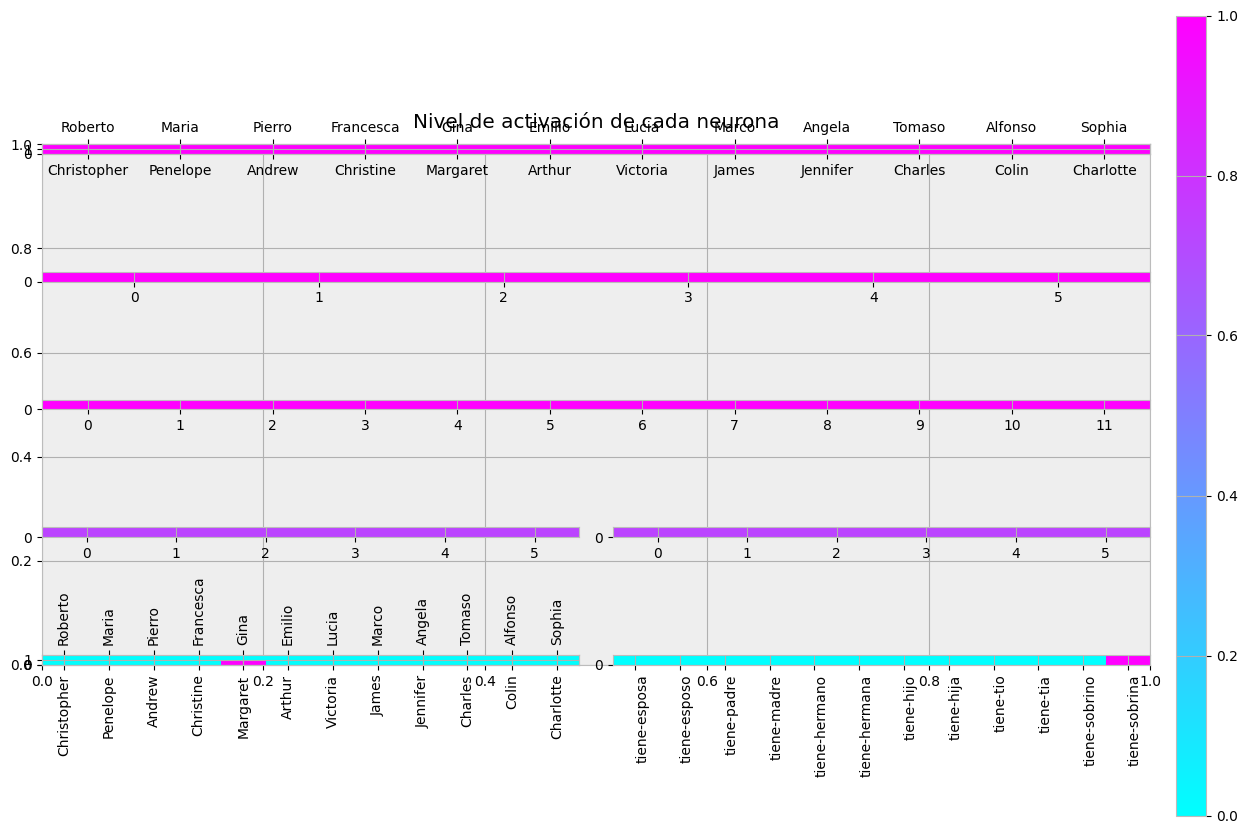

In [22]:
# Grafiquemos los valores de activación de cada neurona para una entrada dada.

from RedHinton.plot import *

def interpretaRespuesta(redHinton, iEntrada, printBits = False):
    """ Imprime la tercia, según las activaciones en la red. """
    if printBits:
        print("a_1 = ", redHinton.a_1[iEntrada,:])
        print("a_2 = ", redHinton.a_2[iEntrada,:])
        print("e = ", redHinton.e[iEntrada,:])
    p1 = decodificaPersona(redHinton.a_1[iEntrada,:])
    r = decodificaRelacion(redHinton.a_2[iEntrada,:])
    p2 = decodificaPersona(redHinton.e[iEntrada,:])
    
    print(" ".join(p1 + r), p2)
    
plotNetworkActivity(RH_0, 0, True)
interpretaRespuesta(RH_0, 0, True)

## Retropropagación
Para entrenar a la red neuronal y calcular los pesos correctos automáticamente, utilizaremos el algoritmo de retropropagación.

**Tip de los expertos**: Es importante inicializar los pesos para la red en forma aleatoria, para romper la simetría y asegurar que cada neurona aprenda cosas diferentes acerca de los datos.  Se sugiere que los valores se encuentren distribuidos uniformente en el rango $[-\epsilon_{init}, \epsilon_{init}]$, donde $\epsilon_{init}$ puede estar dada por:

\begin{align}
  \epsilon_{init} = \dfrac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}
\end{align}
con $L_{in}$, el número de neuronas en la capa $l$ y $L_{out}$ el número de neuronas en la capa $l+1$.

In [23]:
## Agreguemos un método a la neurona para que asigne pesos aleatorios.

def asignaPesosAleatorios(self):
    """
    Asigna pesos aleatorios a todas las conexiones.
    Útil para inicializar el entrenamiento.
    """
    epsilon_init = 0.3;
    self.zb_1.weight.data = torch.rand(self.zb_1.weight.data.size(), dtype=torch.double) * 2 * epsilon_init - epsilon_init
    self.zb_2.weight.data = torch.rand(self.zb_2.weight.data.size(), dtype=torch.double) * 2 * epsilon_init - epsilon_init
    self.zc.weight.data = torch.rand(self.zc.weight.data.size(), dtype=torch.double) * 2 * epsilon_init - epsilon_init
    self.zd.weight.data = torch.rand(self.zd.weight.data.size(), dtype=torch.double) * 2 * epsilon_init - epsilon_init
    self.ze.weight.data = torch.rand(self.ze.weight.data.size(), dtype=torch.double) * 2 * epsilon_init - epsilon_init
setattr(ModeloFamiliar, 'asignaPesosAleatorios', asignaPesosAleatorios)

In [24]:
## Visualicemos el efecto para cada ejemplar
RH_A = ModeloFamiliar()
RH_A.asignaPesosAleatorios()

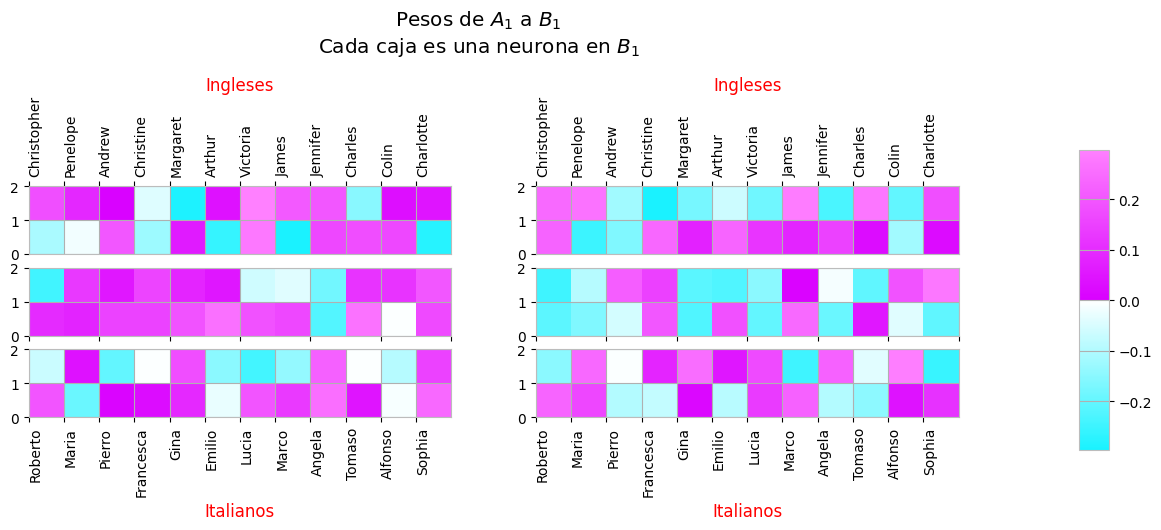

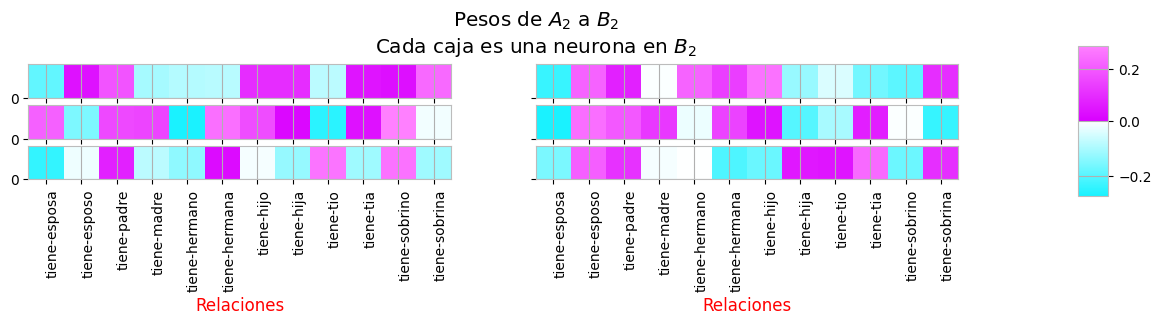

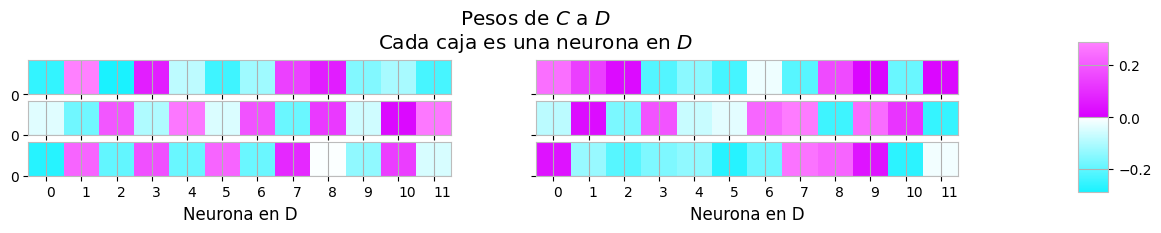

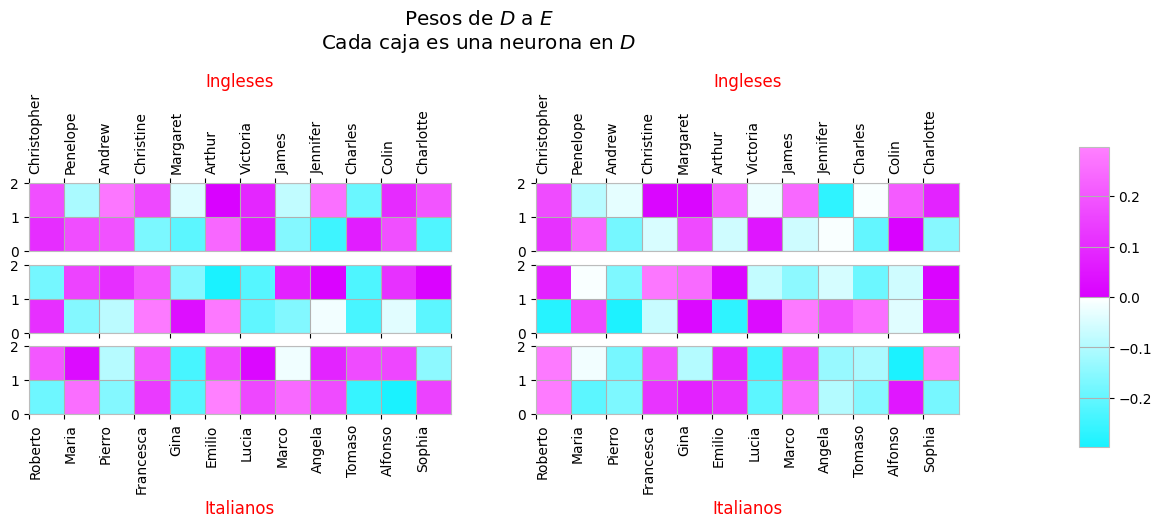

In [25]:
# Grafiquemos los valores de los pesos que conectan a las neuronas.
muestraPesos(RH_A, pyTorch=True)

In [26]:
RH_A.forward(X)

@interact(index = (0, len(X)) )
def plotActivityTest(index):
    plotNetworkActivity(RH_A, index, pyTorch=True)
    interpretaRespuesta(RH_A, index, False)

interactive(children=(IntSlider(value=50, description='index'), Output()), _dom_classes=('widget-interact',))

### La función de error
Consideremos ahora a todos los ejemplares de entrenamiento, formando a la matriz $\mathbf{X}$, con cada renglón conteniendo las entradas de las neuronas en la primera capa, y las salidas para cada ejemplar en los renglones de la matriz $\mathbf{Y}$.
 \begin{align}
  \mathbf{X} &= \begin{bmatrix}
       x_0^{(1)} x_1^{(1)} ... x_{s_0}^{(1)}  \\
       x_0^{(2)} x_1^{(2)} ... x_{s_0}^{(2)}  \\
       ...\\
       x_0^{(m)} x_1^{(m)} ... x_{s_0}^{(m)}
      \end{bmatrix} &
  \mathbf{Y} &= \begin{bmatrix}
       y_0^{(1)} y_1^{(1)} ... y_{s_{L-1}}^{(1)}  \\
       y_0^{(2)} y_1^{(2)} ... y_{s_{L-1}}^{(2)}  \\
       ...\\
       y_0^{(m)} y_1^{(m)} ... y_{s_{L-1}}^{(m)}
      \end{bmatrix}
 \end{align}

En este ejemplo utilizaremos la misma función de error que utilizó Hinton, el error cuadrático:
\begin{align}
  E =& \frac{1}{2m} \sum_{i=0}^{M-1} \sum_{k=0}^{K-1} (y_{ik} - a_{ik})^2
\end{align}
donde:
  * $M$ es el número de ejemplares de entrenamiento y
  * $K$ es el número de neuronas de salida.

In [27]:
def train(model, X, Y, X_test, Y_test, learning_rate=0.01, momentum=0.5, weight_decay=0, num_steps=500, alpha=0.75):
    """
    Recibe el modelo de red neuronal a entrenar,
    los datos de entrada X y los valores de salida deseados Y
    en tensores de PyTorch
    """
    errores = np.zeros(num_steps)
    errores_test = np.zeros(num_steps)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, dampening=0, weight_decay=weight_decay, nesterov=True)
    #optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate, lambd=0.0001, alpha=alpha, weight_decay=weight_decay) # Averaged Stochastic Gradient Descent
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, weight_decay=weight_decay, momentum=0.5) # Adaptive lr
    #optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, weight_decay=weight_decay) # Adaptive lr
    #optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01,lr_decay=0,weight_decay=weight_decay) # Adaptive subgradient
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()       # Mean Squared Error
    
    for t in range(num_steps):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X)

        # Compute and print loss
        loss = criterion(torch.clamp(y_pred, 0.2, 0.8), torch.clamp(Y, 0.2, 0.8))
        errores[t] = loss.item()

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Test set
        y_test_pred = model(X_test)
        #if t == num_steps - 1:
        #    print(torch.clamp(y_test_pred, 0.2, 0.8))
        #    print(torch.clamp(Y_test, 0.2, 0.8))
        test_loss = criterion(torch.clamp(y_test_pred, 0.2, 0.8), torch.clamp(Y_test, 0.2, 0.8))
        errores_test[t] = test_loss.item()
    if num_steps > 1:
        # Grafica error
        steps = np.arange(num_steps)
        plt.plot(steps, errores, label='Entrenamiento')
        #plt.plot(steps, errores_test, label='Prueba') # A veces estorba
        plt.legend()
        plt.title("Error")
        plt.ylabel("Error cuadrático medio")
        plt.xlabel("Iteración")
    print("Final error = ", errores[-1])

In [28]:
# Reset RH_A values
@interact_manual()
def restart():
    RH_A.asignaPesosAleatorios()
    print("Reasignando valores aleatorios a los pesos de la red")

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [29]:
num_clicks = 0
@interact_manual()
def mini_entrena():
    train(RH_A, X, Y, XTest, YTest, learning_rate=5, momentum=0.55, weight_decay=0.0001, num_steps=2000)
    global num_clicks
    num_clicks += 1
    print("Run:", num_clicks)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [30]:
RH_A_backup = ModeloFamiliar()

@interact_manual()
def backup():
    RH_A_backup.load_state_dict(RH_A.state_dict())
    print("Se guardó el estado actual de la red.")

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [31]:
@interact_manual()
def restore():
    RH_A.load_state_dict(RH_A_backup.state_dict())
    print("Se restauró el último estado guardado de la red")

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [32]:
@interact_manual()
def saveNetwork():
    torch.save(RH_A.state_dict(), PATH)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [33]:
@interact_manual()
def loadNetwork():
    global RH_A
    RH_A = ModeloFamiliar()
    state_dict = torch.load(PATH)
    RH_A.load_state_dict(state_dict)
    RH_A.double()
    print("Se cargó el archivo con los pesos de la red")

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [34]:
# Correr 5 veces
num_clicks_2 = 0
@interact_manual()
def entrenaRH_A_Simple():
    train(RH_A, X, Y, XTest, YTest, learning_rate=15.0, momentum=0.009, weight_decay=0.0, num_steps=10000)
    global num_clicks_2
    num_clicks_2 += 1
    print(num_clicks_2)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [35]:
# Correr 2 veces
num_clicks_3 = 0
@interact_manual()
def entrenaRH_A_Simple():
    train(RH_A, X, Y, XTest, YTest, learning_rate=50, momentum=0.009, weight_decay=0.0, num_steps=10000)
    global num_clicks_3
    num_clicks_3 += 1
    print(num_clicks_3)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<img width="400" src="figuras/ArbolGenealogico.png"/>

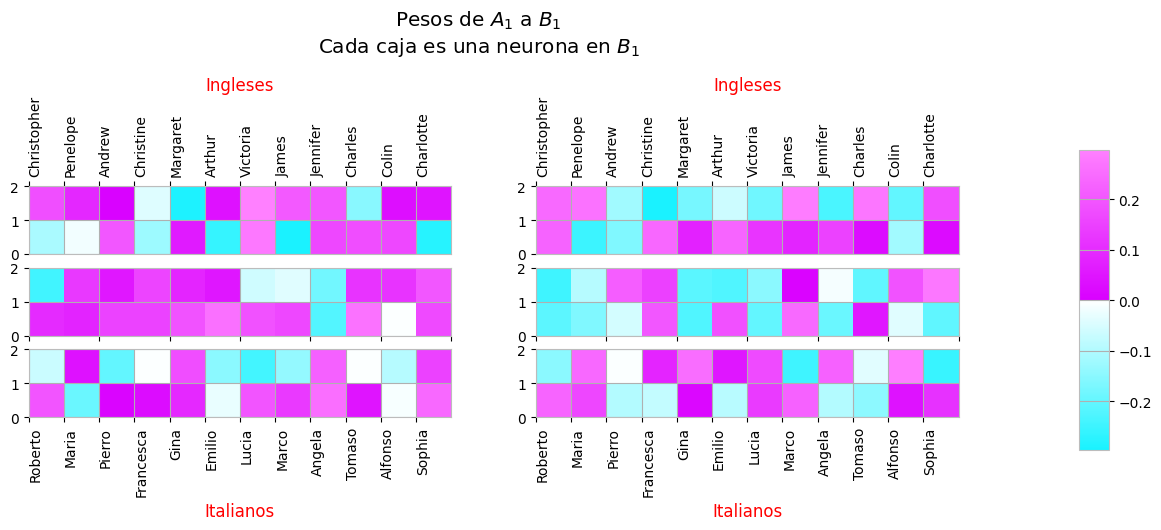

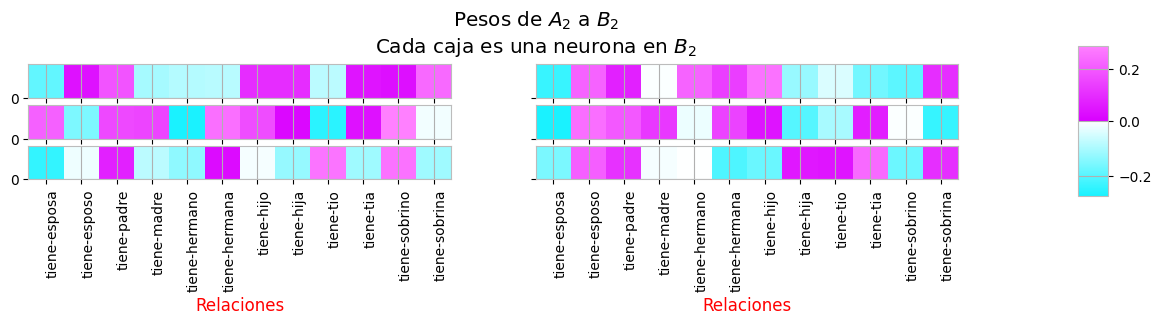

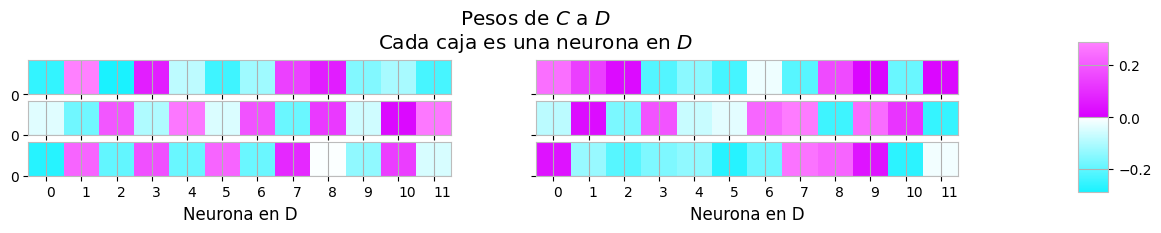

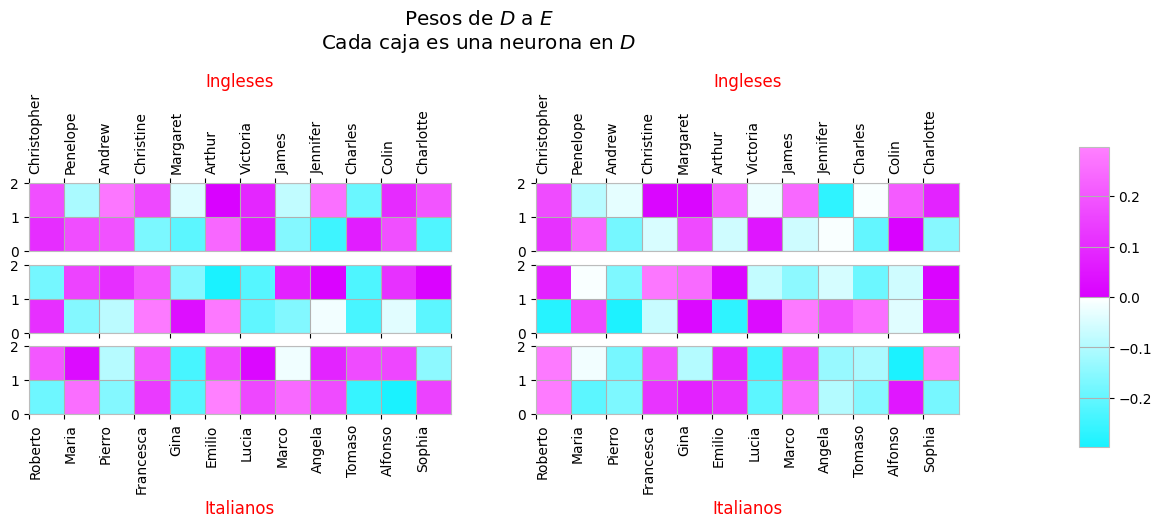

In [36]:
muestraPesos(RH_A, pyTorch=True)

In [37]:
#print(RH_B.Wa_1, RH_B.Wa_2, RH_B.Wd)

In [38]:
@interact(index = (0, len(Datos) - 1))
def plotActivityTest(index):
    RH_A(torch.tensor(Datos[np.newaxis, index]))
    plotNetworkActivity(RH_A, 0, pyTorch=True)
    interpretaRespuesta(RH_A, 0, False)
    print("Se esperaba ", decodificaPersona(Salidas[index]))

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [38]:
def responde(self, persona1, relacion, showBits = False):
    a_1 = codificaPersona(persona1)
    a_2 = codificaRelacion(relacion)
    X = torch.tensor(np.vstack((a_1, a_2)).T)
    self(X)
    arr_personas2 = self.e.detach().numpy()[0]
    personas2 = decodificaPersona(arr_personas2)
    interpretaRespuesta(self, 0, showBits)
    return personas2
setattr(ModeloFamiliar, 'responde', responde)

In [39]:
RH_A.responde('Arthur', 'tiene-padre')

Arthur tiene-padre ['Penelope', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Marco']


['Penelope',
 'Christine',
 'Margaret',
 'Arthur',
 'Victoria',
 'Roberto',
 'Maria',
 'Pierro',
 'Francesca',
 'Marco']

In [40]:
# Desempeño en el conjunto de prueba
for i in range(mTest):
    persona1 = decodificaPersona(XTest[i][0:24])
    relacion = decodificaRelacion(XTest[i][24:])
    persona2 = decodificaPersona(YTest[i])
    persona2_res = RH_A.responde(persona1[0], relacion[0])
    print("Se esperaba ", persona2 , "\n")
    

Marco tiene-padre ['Penelope', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Marco']
Se esperaba  ['Pierro'] 

Victoria tiene-hija ['Penelope', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Marco']
Se esperaba  ['Charlotte'] 

James tiene-hijo ['Penelope', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Marco']
Se esperaba  ['Colin'] 

Jennifer tiene-sobrina ['Penelope', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Marco']
Se esperaba  ['Charlotte'] 



# Evaluación

Como se puede ver en las gráficas anteriores, esta red aprendió a minimizar el error global, pero no aprendió a predecir quien(es) son las personas que deben aparecer en la tercera posición de la tupla.  ¡Nisiquiera para los datos de entrenamiento!  En unos momentos estudiaremos qué se puede hacer al respecto.

## Matriz de confusión
Para comenzar veremos qué tan mal está y a dónde llegó la red después del proceso de minimización.  Para ello se requiere una medida más eficiente que la función de error.  Calcularemos los valores de la matriz de confusión, comparando los valores deseados, contra los valores de salida en cada neurona de la última capa, después de aplicar un función umbral.

<table>
<thead>
<tr><th colspan="2"></th><th colspan="2">Clase predicha</th></tr>
<tr><th colspan="2"></th><th>1</th><th>0</th></tr>
</thead>
<tr><th rowspan="2">Clase correcta</th><th>1</th><td>TP</td><td>FN</td></tr>
<tr><th>0</th><td>FP</td><td>TN</td></tr>
</table>

In [61]:
def matrizDeConfusion(redHinton, X, Y):
    """ Calcula los elementos de la matriz de confusión,
    considerando las diferencias, neurona por neurona, entre
    la predicción obtenida (después de aplicar la función umbral)
    y la deseada, para cada ejemplar en (X, Y)
    """
    y_pred = redHinton(X)
    
    #thr = np.zeros(redHinton.e.shape)
    #thr[redHinton.e >= 0.5] = 1
    thr = np.zeros(Y.size())
    thr[y_pred >= 0.5] = 1
    
    numElemems = Y.shape[0] * Y.shape[1]
    prediccion = thr.astype(bool)
    etiquetas = Y.numpy().astype(bool)
    
    matriz = np.zeros((2,2))
    TP = np.logical_and(prediccion, etiquetas)
    matriz[0][0] = np.sum(TP)
    
    TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
    matriz[1][1] = np.sum(TN)
    
    FP = np.logical_and(np.logical_not(etiquetas), prediccion)
    matriz[1][0] = np.sum(FP)
    
    FN = np.logical_and(etiquetas, np.logical_not(prediccion))
    matriz[0][1] = np.sum(FN)
    
    return matriz
np.set_printoptions(suppress=True)
print("TP FN\nFP TN")
ent = matrizDeConfusion(RH_A, X, Y)
test = matrizDeConfusion(RH_A, XTest, YTest)
print("Entrenamiento", ent)
print("Prueba", test)

TP FN
FP TN
Entrenamiento [[ 106.    2.]
 [   0. 2292.]]
Prueba [[ 3.  1.]
 [ 3. 89.]]


In [42]:
a = np.array([True, False, True, True, False])

In [43]:
np.sum(a)

3

Rosa es 1, azul es 0

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


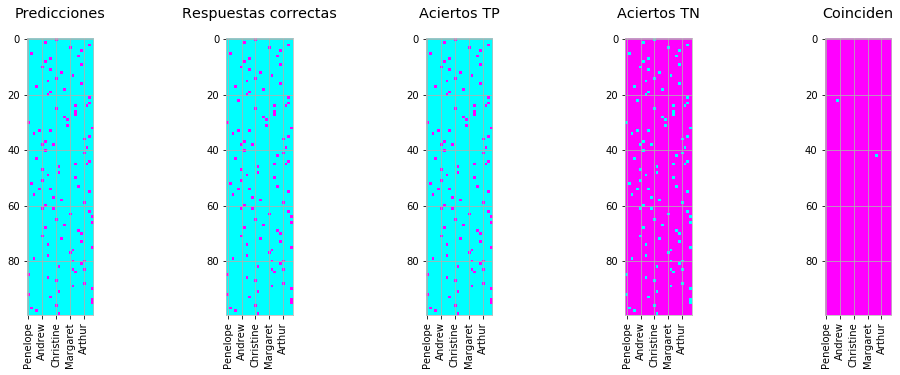

In [58]:
from sklearn.metrics import confusion_matrix

def matrizDeConfusionCompleta(redHinton, X, Y):
    y_pred = redHinton(X).data.numpy()
    nL = Y.size()[1]
    
    thr = np.zeros(Y.size())
    thr[y_pred >= 0.5] = 1
    prediccion = thr.astype(bool)
    etiquetas = Y.numpy().astype(bool)
    
    TP = np.logical_and(prediccion, etiquetas)
    TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
    coinciden = np.logical_not(np.logical_xor(prediccion, etiquetas))
    
    #confusion = np.zeros((nL, nL))
    #confusion = confusion_matrix(etiquetas, y_pred)
    
    fig = plt.figure(figsize=(14,14))
    
    ax = fig.add_subplot(351)
    cax = ax.matshow(prediccion, cmap=cm.cool)
    ax.set_xticklabels(personas, rotation=90)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("Predicciones")
    #ax.set_aspect(aspect=0.25)
    
    ax = fig.add_subplot(352)
    cax = ax.matshow(etiquetas, cmap=cm.cool)
    ax.set_xticklabels(personas, rotation=90)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("Respuestas correctas")
    
    ax = fig.add_subplot(353)
    cax = ax.matshow(TP, cmap=cm.cool)
    ax.set_xticklabels(personas, rotation=90)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("Aciertos TP")
    
    ax = fig.add_subplot(354)
    cax = ax.matshow(TN, cmap=cm.cool)
    ax.set_xticklabels(personas, rotation=90)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("Aciertos TN")
    
    ax = fig.add_subplot(355)
    cax = ax.matshow(coinciden, cmap=cm.cool)
    ax.set_xticklabels(personas, rotation=90)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("Coinciden")
    
    #fig = plt.figure()
    
    #ax = fig.add_subplot(111)
    #cax = ax.matshow(confusion, cmap=cm.cool)
    #ax.set_xticks(np.arange(nL))
    #ax.set_yticks(np.arange(nL))
    #ax.set_xticklabels(personas, rotation=90)
    #ax.set_yticklabels(personas)
    #ax.set_title("Matriz de confusión")
    
    plt.tight_layout()
    #plt.colorbar(cax)
    print("Rosa es 1, azul es 0\n")
    print(coinciden)
    
# TODO: ¿Tiene sentido esta matriz en este contexto?    
#matrizDeConfusionCompleta(RH_A, XTest, YTest)
matrizDeConfusionCompleta(RH_A, X, Y)